# Social Recommendation Systems (CiaoDVD Dataset)

## Goal
The aim of this project is to build a tool that implements and compares different types of recommendation algorithms on a real-world dataset. The tool should be able to: 
- Load the dataset 
- Run different recommendation algorithms on the dataset 
- Compare and discuss the results, parameter sensitivity

### Task 1. Load the dataset
- Load the CiaoDVD dataset from https://www.librec.net/datasets.html
- Explore the properties of the graph

In [1]:
# Import all the modules and dependencies required 
import pandas as pd
import numpy as np
import warnings

# Widgets for graphical interface
import ipywidgets as widgets
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, clear_output

import plots
import splitData
import metrics

# Used to get multiple outputs per cell
InteractiveShell.ast_node_interactivity = "all"

warnings.filterwarnings("ignore")  # ignore warnings in logs

#### Loading Dataset

In [2]:
# Loading Dataset
headers = ['userId', 'movieId', 'movie_categoryId', 'reviewId', 'movieRating', 'reviewDate']
columns = ['userId', 'movieId', 'movie_categoryId', 'movieRating']
dataset = pd.read_csv('Dataset/movie-ratings_test.txt',
                           names=headers, usecols=columns, dtype={"userId": "str", "movieId": "str"})
# Dataset information
print('Dataset information')
num_users = dataset.userId.unique().shape[0]
num_items = dataset.movieId.unique().shape[0]
sparsity = 1 - len(dataset) / (num_users * num_items)
print(f"Users: {num_users}\nMovies: {num_items}\nSparsity: {sparsity}")
dataset.info()
dataset.describe()

Dataset information
Users: 14
Movies: 9
Sparsity: 0.626984126984127
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   userId            47 non-null     object
 1   movieId           47 non-null     object
 2   movie_categoryId  47 non-null     int64 
 3   movieRating       47 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 1.6+ KB


,movie_categoryId,movieRating
count,47.000000,47.000000
mean,1.021277,2.914894
std,0.145865,1.457064
min,1.000000,1.000000
25%,1.000000,1.500000
50%,1.000000,3.000000
75%,1.000000,4.000000
max,2.000000,5.000000


#### Rating Analysis

,count,mean,std,min,25%,50%,75%,max
movieRating,9.0,2.603968,0.798475,1.5,2.333333,2.5,3.0,3.785714



Ratings per Movie


,movieRating,ratings_per_movie
movieId,,
1,3.785714,14
2,2.500000,8
4,2.400000,5
3,3.000000,4
6,3.750000,4


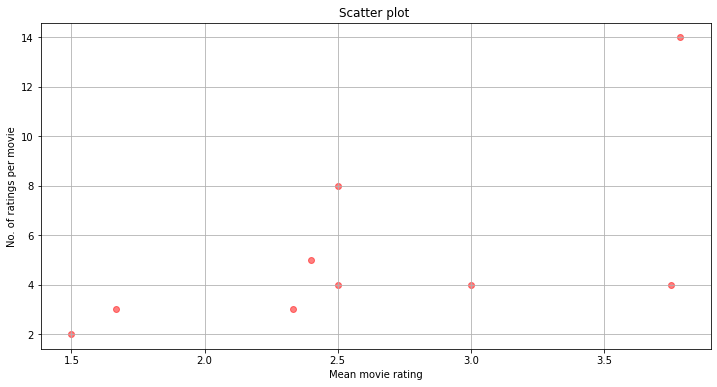

In [3]:
# average rating for each movie
ratings = pd.DataFrame(dataset.groupby('movieId')['movieRating'].mean())

ratings.describe().T

# quantity of ratings per movie
ratings['ratings_per_movie'] = dataset.groupby('movieId')['movieRating'].count()

# sorted by number of ratings
print('\nRatings per Movie')
ratings.sort_values('ratings_per_movie', ascending=False).head()

# Plot number of movies per rating
plots.scatterPlot(ratings)

#### Split the dataset in training and testing data

In [4]:
# Split the Dataset in train 80% and test 20%
train_data, test_data = splitData.split_train_test(dataset, 0.2)

# From here the train_data is the dataset to make the computings
# and test_data is only for measures after the results
print('Train Dataset')
train_data
print('\nTest Dataset')
test_data

Train Dataset


userId,1,10,2,3,4,5,6,7,9,a,b,c,d
movieId,,,,,,,,,,,,,
1,5.0,4.0,NaN,5.0,4.0,4.0,5.0,4.0,3.0,NaN,3.0,3.0,1.0
2,2.0,NaN,1.0,2.0,2.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,2.0
3,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,2.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,5.0
5,2.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
6,NaN,NaN,NaN,NaN,NaN,5.0,1.0,NaN,NaN,5.0,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,3.0
a,1.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b,NaN,NaN,NaN,1.0,NaN,NaN,5.0,NaN,NaN,3.0,NaN,NaN,NaN



Test Dataset


userId,2,4,7,8,a,c,d
movieId,,,,,,,
1,5.0,NaN,NaN,4.0,3.0,NaN,NaN
2,NaN,NaN,4.0,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,4.0,NaN,NaN,1.0
4,NaN,3.0,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,4.0,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,1.0,NaN
b,NaN,1.0,NaN,NaN,NaN,NaN,NaN


#### User ratings average values

User ratings avg.


userId
1     2.5
10    4.0
2     2.5
3     2.5
4     3.0
5     3.2
6     3.0
7     4.0
9     3.0
a     4.0
b     2.0
c     3.0
d     2.4
dtype: float64

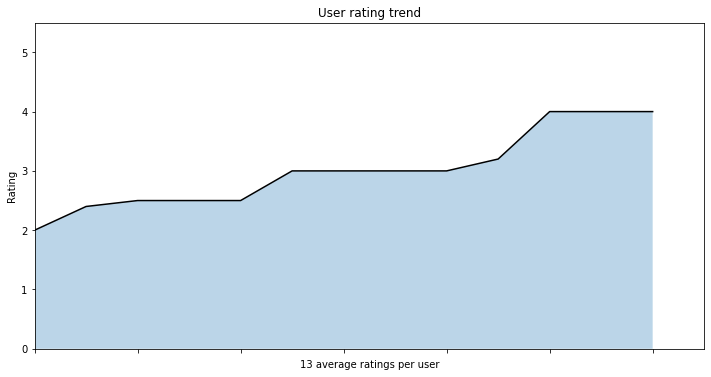

In [5]:
# We get the average of all the movie ratings for each user
user_mean = train_data.mean(axis=0, skipna=True)
# Print the user ratings mean value
print('User ratings avg.')
user_mean

# Plot number of movies per rating
plots.avg_ratings_per_user(user_mean)

### User based Collaborative Filtering Recommender with pearson correlation coefficient

#### Pearson correlation coeficient

In [7]:
def get_pearson_correlation(train_data, user):
    # correlation between the movies: indicates the extent to which two or more variables fluctuate together
    # high correlation coefficient are the movies that are most similar to each other

    # ************** Pearson Coefficient Correlation ********************
    # Pearson correlation coefficient: this will lie between -1 and 1
    pearson_corr = train_data.corrwith(train_data[user], method='pearson')
    # print(f"Correlation for user{user}\n{pearson_corr}")

    return pearson_corr

#### Setting global variables

In [23]:
# The number of neighbors for the prediction
k = widgets.IntText(value= 5, description= "k size: ", disable= False)
# The min and max boundaries for the score
bounds = (1,5) 
# Value used for neighborhood selection
threshold = widgets.FloatSlider(value= 0.25, min= -1, max= 1, description= 'Thresh. sim: ')
# Button to start computing
button = widgets.Button(description="Run")
output = widgets.Output()

def on_button_clicked(b):
    with output:
        clear_output()
        print('Pearson correlation')
        display(get_pearson_correlation(train_data, 'd'))
button.on_click(on_button_clicked)

# Widgets interface
k
threshold
display(button, output)

IntText(value=5, description='k size: ')

FloatSlider(value=0.25, description='Thresh. sim: ', max=1.0, min=-1.0)

Button(description='Run', style=ButtonStyle())

Output()